In [ ]:
!pip install keras
!pip install pydot graphviz


In [ ]:
import numpy as np
import pandas as pd

sectors_data = {}
excel_file_path = 'logreturns_2000_2020_data_by_sector.xlsx'
snp_price_data = pd.ExcelFile(excel_file_path)
for sheet_name in snp_price_data.sheet_names:
    sheet_data = pd.read_excel(excel_file_path, sheet_name=sheet_name)
    sheet_data['Date'] = pd.to_datetime(sheet_data['Unnamed: 0'], format='%Y-%m-%d')
    sheet_data.set_index('Date', inplace=True)
    sheet_data.drop(columns='Unnamed: 0', inplace=True)
    sectors_data[sheet_name] = sheet_data

# 데이터프레임 생성
df = pd.DataFrame()
for sector, data in sectors_data.items():
    data.columns = [f"{sector}_{col}" for col in data.columns]
    if df.empty:
        df = data
    else:
        df = df.join(data, how='outer')

df = df[1:]

In [ ]:
#스케일링을 위한 학습데이터와 테스트데이터 셋 분리
train_scaling_size = int(len(df) * 0.7)
t_train_X = df[0 : train_scaling_size]
t_train_y = df[0 : train_scaling_size]


# 전체 데이터 중 최소값과 최대값 구하기
tot_train_min = np.minimum.reduce([t_train_X.min(axis=0), t_train_X.min(axis=0)])
tot_train_max = np.maximum.reduce([t_train_X.max(axis=0), t_train_X.max(axis=0)])

# 각 주식의 범위를 계산
train_range = tot_train_max - tot_train_min

In [ ]:
import pandas as pd

end_date = pd.Timestamp('2020-12-31')
one_month = pd.DateOffset(months=1)
sixty_days = pd.DateOffset(days=60)

data_X = []
data_y = []
start_day_idx = [] # data_X를 생성하기 위한 매달 시작일 인덱스 리스트

# data_y부터 생성
start_date = pd.Timestamp('2000-04-01')

while start_date < end_date:
    end_of_period = start_date + pd.DateOffset(months=1) - pd.DateOffset(days=1)
    selected_data = df[(df.index >= start_date) & (df.index <= end_of_period)]

    indexing = df.index.get_loc(selected_data.index[0])

    # 각 주식에 대한 월별 평균 수익률 계산
    average_values = selected_data.mean(axis=0)

    data_y.append(average_values)
    start_day_idx.append(indexing)
    start_date = start_date + pd.DateOffset(months=1)  # Move to next month

start_date = pd.Timestamp('2000-01-01')

i = 0
while i < len(data_y):
    index_day_start = start_day_idx[i]

    nearest_index = None
    for j in range(index_day_start - 1, index_day_start - 61, -1):
        if j < 0:
            break
        if df.index[j] in df.index:
            nearest_index = j
            break

    if nearest_index is not None:
        sixty_day_data = df.iloc[nearest_index - 60 : nearest_index]
        data_X.append(sixty_day_data)
    else:
        pass

    i += 1



# 월별로 생성하는 방식 (data_X)
# start_date = pd.Timestamp('2000-04-01')

# while start_date < end_date:
#     start_of_period = start_date - pd.DateOffset(months=3)
#     selected_data = df[(df.index >= start_of_period) & (df.index < start_date)]

#     data_X.append(selected_data)
#     start_date = start_date + pd.DateOffset(months=1)  # Move to next month


In [ ]:
#학습데이터와 테스트데이터 셋 분리
train_size = int(len(data_y) * 0.7)
train_X = np.array(data_X[0 : train_size])
train_y = np.array(data_y[0 : train_size])

# test_size = len(data_y) - train_size
test_X = np.array(data_X[train_size : len(data_X)])
test_y = np.array(data_y[train_size : len(data_y)])

# #테스트데이터는 전체 데이터로~
# test_X = np.array(data_X)
# test_y = np.array(data_y)

print('훈련 데이터의 크기 :', train_X.shape, train_y.shape)
print('테스트 데이터의 크기 :', test_X.shape, test_y.shape)

훈련 데이터의 크기 : (174, 60, 55) (174, 55)
테스트 데이터의 크기 : (75, 60, 55) (75, 55)


In [ ]:
# 스케일링
train_X = (train_X - tot_train_min) / (train_range + 1e-7)
train_y = (train_y - tot_train_min) / (train_range + 1e-7)
test_X = (test_X - tot_train_min) / (train_range + 1e-7)
test_y = (test_y - tot_train_min) / (train_range + 1e-7)



# # 스케일링된 데이터를 저장할 리스트 초기화
# train_X_scaled = []
# test_X_scaled = []
# # 학습 데이터 스케일링
# for X in train_X:
#     X_scaled = (X - tot_train_min) / (train_range + 1e-7)
#     train_X_scaled.append(X_scaled)
# # 테스트 데이터 스케일링
# for X in test_X:
#     X_scaled = (X - tot_train_min) / (train_range + 1e-7)
#     test_X_scaled.append(X_scaled)
# # 리스트를 numpy 배열로 변환
# train_X_scaled = np.array(train_X_scaled)
# test_X_scaled = np.array(test_X_scaled)

In [ ]:
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.initializers import RandomNormal

# 가중치 초기화 방법 설정
init = RandomNormal(mean=0., stddev=0.01)

model1 = Sequential()
model1.add(LSTM(units=55, activation='relu', return_sequences=True, input_shape=(60, 55)))
model1.add(Dropout(0.1))
model1.add(LSTM(units=55, activation='relu', return_sequences=True, kernel_initializer=init))
model1.add(Dropout(0.1))
model1.add(Dense(units=55, kernel_initializer=init))
model1.summary()

model2 = keras.models.Sequential([
  keras.layers.Input(shape=(60, 55)),
  keras.layers.LSTM(55, activation="relu", return_sequences=True),
  keras.layers.Dropout(0.3),
  keras.layers.LSTM(256, activation="relu", return_sequences=True),
  keras.layers.Dropout(0.2),
  keras.layers.LSTM(128, activation="relu", return_sequences=False),
  keras.layers.Dropout(0.1),
  keras.layers.Dense(55),
])
model2.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_33 (LSTM)              (None, 60, 55)            24420     
                                                                 
 dropout_27 (Dropout)        (None, 60, 55)            0         
                                                                 
 lstm_34 (LSTM)              (None, 55)                24420     
                                                                 
 dropout_28 (Dropout)        (None, 55)                0         
                                                                 
 dense_9 (Dense)             (None, 55)                3080      
                                                                 
Total params: 51920 (202.81 KB)
Trainable params: 51920 (202.81 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_35 (LSTM)              (None, 60, 55)            24420     
                                                                 
 dropout_29 (Dropout)        (None, 60, 55)            0         
                                                                 
 lstm_36 (LSTM)              (None, 60, 256)           319488    
                                                                 
 dropout_30 (Dropout)        (None, 60, 256)           0         
                                                                 
 lstm_37 (LSTM)              (None, 128)               197120    
                                                                 
 dropout_31 (Dropout)        (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 55)              

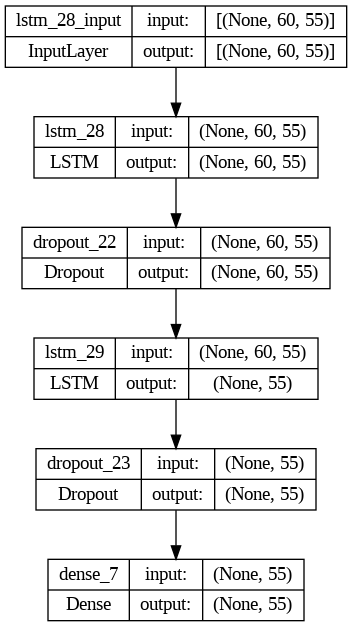

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model1, to_file='model.png', show_shapes=True, show_layer_names=True)


In [ ]:
# 옵티마이저와 손실함수 결정 및 학습 실행
model1.compile(optimizer='adam', loss='mean_squared_error')
model1.fit(train_X, train_y, epochs=500, batch_size=256)

model2.compile(optimizer='adam', loss='mean_squared_error')
model2.fit(train_X, train_y, epochs=100, batch_size=128)

Epoch 1/500
1/1 [==============================] - 3s 3s/step - loss: 0.2772
Epoch 2/500
1/1 [==============================] - 0s 172ms/step - loss: 0.1910
Epoch 3/500
1/1 [==============================] - 0s 185ms/step - loss: 13.8103
Epoch 4/500
1/1 [==============================] - 0s 184ms/step - loss: 0.1082
Epoch 5/500
1/1 [==============================] - 0s 183ms/step - loss: 0.2295
Epoch 6/500
1/1 [==============================] - 0s 293ms/step - loss: 0.2558
Epoch 7/500
1/1 [==============================] - 0s 337ms/step - loss: 0.2666
Epoch 8/500
1/1 [==============================] - 0s 377ms/step - loss: 0.2724
Epoch 9/500
1/1 [==============================] - 0s 369ms/step - loss: 0.2759
Epoch 10/500
1/1 [==============================] - 0s 358ms/step - loss: 0.2784
Epoch 11/500
1/1 [==============================] - 0s 371ms/step - loss: 0.2801
Epoch 12/500
1/1 [==============================] - 0s 333ms/step - loss: 0.2813
Epoch 13/500
1/1 [=====================

In [ ]:
#가중치 저장
model.save_weights('LSTM_logreturn_prd_weight.h5')

In [ ]:
model.load_weights('LSTM_logreturn_prd_weight.h5')

In [ ]:
# 예측 결과 얻기
pred_y1 = model1.predict(test_X)
pred_y2 = model2.predict(test_X)

3/3 [==============================] - 1s 189ms/step


In [ ]:
_test_y = test_y * (train_range + 1e-7) + tot_train_min
for i in range(20) :
  for j in range(55) :
      print(test_y[i, j])
      print(_test_y[i, j])

In [ ]:
# _pred_y = pred_y * (train_range + 1e-7) + tot_train_min
for i in range(20) :
  for j in range(55) :
      print(pred_y[i, j])
      # print(_pred_y[i, j])

In [ ]:
test_y = test_y * (train_range + 1e-7) + tot_train_min
pred_y1 = pred_y1 * (train_range + 1e-7) + tot_train_min
pred_y2 = pred_y2 * (train_range + 1e-7) + tot_train_min

In [ ]:
cum_y = np.cumsum(test_y, axis=0)
cum_pred1 = np.cumsum(pred_y1, axis=0)
# cum_pred2 = np.cumsum(pred_y2, axis=0)

In [ ]:
# Assuming predictions is a NumPy array
column_names = [f'Prediction_{i}' for i in range(pred_y.shape[1])]
predictions_df = pd.DataFrame(pred_y, columns=column_names)

# Save predictions to an Excel file
predictions_df.to_excel('model_predictions_logreturns.xlsx', index=False)

In [ ]:
import matplotlib.pyplot as plt

stocks = {
        'Tele' : ['VZ', 'DIS', 'T', 'CMCSA', 'EA'],
        'COND' : ['AMZN', 'HD', 'MCD', 'NKE', 'SBUX'],
        'ENRG': ['XOM', 'CVX', 'COP', 'EOG', 'SLB'],
        'HLCA' : ['JNJ', 'PFE', 'UNH','MRK','ABT'],
        'INDS' : ['BA', 'MMM','UNP','HON','RTX'],
        'MTRS': ['PPG', 'APD', 'ECL', 'SHW', 'NEM'],
        'FINC' : ['JPM', 'BRK-B', 'BAC', 'WFC', 'C'],
        'CONS' : ['PG', 'KO', 'PEP','WMT','MO'],
        'INFT' : ['AAPL','MSFT','INTC','CSCO','ORCL'],
        'UTIL' : ['NEE','DUK','D','SO','EXC'],
        'REES' : ['AMT', 'SPG', 'CCI', 'PLD', 'PSA']
    }



# 각 주식에 대한 그래프 그리기 위해 회사 리스트 생성
company_list = []
for sector in stocks:
    company_list += stocks[sector]

plt.rcParams['font.size'] = 20

# 각 주식 별 예측값&실제값 그래프 그리기
for i, company in enumerate(company_list):
    plt.figure(figsize=(20,10))

    # 실제 데이터 그래프
    plt.plot(test_y[:,i], color='blue', label='Actual Stock Price of ' + company)

    # 예측 데이터 그래프
    plt.plot(pred_y2[:,i], color='red', label='Predicted Stock Price of ' + company)

    plt.title('Stock Price Prediction of ' + company)
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# 각 섹터별 예측값&실제값 그래프 그리기

plt.rcParams['font.size'] = 20

for sector in stocks:
    plt.figure(figsize=(20,10))

    # 실제 데이터 그래프
    avg_test_y = np.mean([test_y[:, company_list.index(company)] for company in stocks[sector]], axis=0)
    plt.plot(avg_test_y, color='blue', label='Average Real Stock Price of ' + sector)

    # 예측 데이터 그래프
    avg_pred_y = np.mean([pred_y2[:, company_list.index(company)] for company in stocks[sector]], axis=0)
    plt.plot(avg_pred_y, color='red', label='Average Predicted Stock Price of ' + sector)

    plt.title('Average Stock Price Prediction of ' + sector, fontsize=36)
    plt.xlabel('Time', fontsize=36)
    plt.ylabel('Stock Price', fontsize=36)
    plt.legend()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

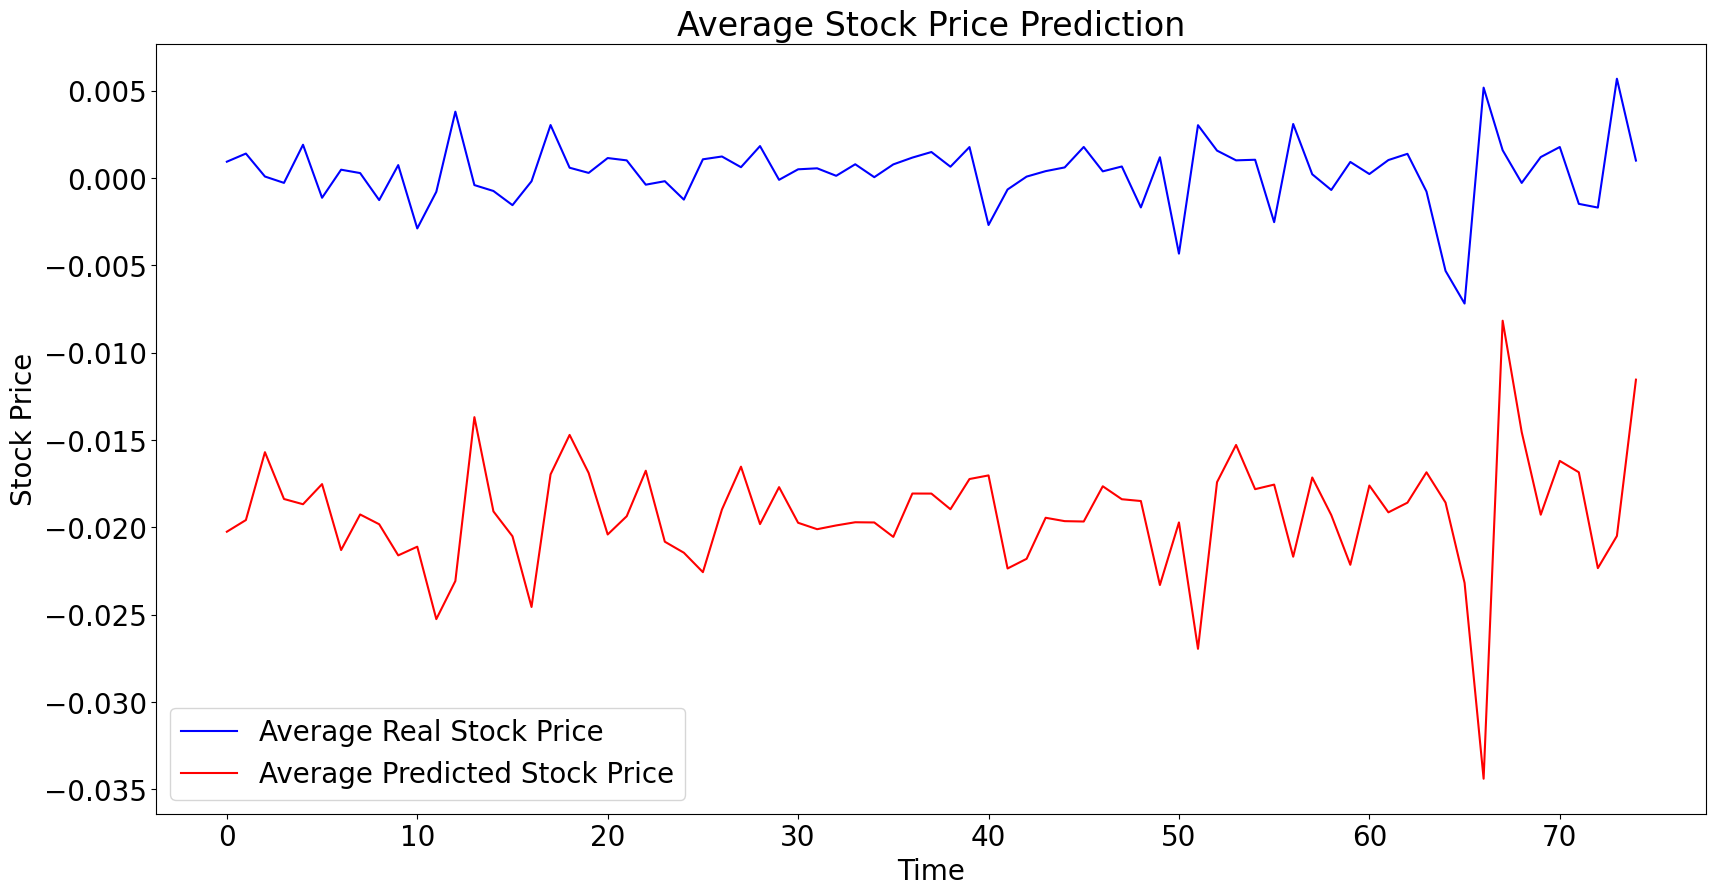

In [ ]:
# 모든 주식의 평균 예측값& 실제값 그래프 그리기

plt.rcParams['font.size'] = 20

plt.figure(figsize=(20,10))

# 실제 데이터 그래프
avg_test_y = np.mean(test_y, axis=1)
plt.plot(avg_test_y, color='blue', label='Average Real Stock Price')

# 예측 데이터 그래프
avg_pred_y = np.mean(pred_y2, axis=1)
plt.plot(avg_pred_y, color='red', label='Average Predicted Stock Price')

plt.title('Average Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
